In [32]:
!pip install gurobipy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import gurobipy as gp

In [34]:
import os
import gurobipy as gp
from gurobipy import GRB, quicksum

params = {
    "WLSACCESSID": os.getenv("GRB_WLSACCESSID", '35a382ab-2f66-4f8c-93e5-29e3ae8a72c9'),
    "WLSSECRET":   os.getenv("GRB_WLSSECRET",   '697d9c6e-319b-4535-8f62-9fd78101f77d'),
    "LICENSEID":   int(os.getenv("GRB_LICENSEID", "2610074")),
    # optional quality-of-life settings:
    "OutputFlag":  0,          # silence logs for cleaner notebooks
    "CSClientLog": 0,          # silence WLS client logs
}
env = gp.Env(params=params)
env.start()
print("Gurobi environment ready.")


Gurobi environment ready.


In [35]:
!pip install yfinance --upgrade --no-cache-dir


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from gurobipy import GRB

In [44]:
def get_nasdaq100_tickers():

    url = 'https://en.wikipedia.org/wiki/Nasdaq-100'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                             'AppleWebKit/537.36 (KHTML, like Gecko) '
                             'Chrome/120.0.0.0 Safari/537.36'}

    response = requests.get(url, headers=headers)
    response.raise_for_status()  #raises an HTTPError if status != 200

    tables = pd.read_html(response.text)

    for table in tables:
      if 'Ticker' in table.columns:
        tickers = table['Ticker'].tolist()

        tickers = [str(ticker).strip() for ticker in tickers
                  if pd.notna(ticker) and ticker != 'nan']
    print(tickers)

    return tickers

tickers = get_nasdaq100_tickers()

def download_data(tickers, start_date, end_date, timeout=30): 
    #download data
    data = yf.download(tickers, start=start_date, end=end_date, 
                       progress=False, auto_adjust=False)
    
    prices = data['Adj Close']

    #forward fill and backward fill to handle missing days
    prices = prices.ffill().bfill()
    
    #drop columns with any remaining NaN values
    prices = prices.dropna(axis=1)
    #calculate returns
    returns = prices.pct_change().dropna()
    
    return prices, returns

['ADBE', 'AMD', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI', 'AAPL', 'AMAT', 'APP', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'AXON', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MSTR', 'MDLZ', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PLTR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SHOP', 'SOLS', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TXN', 'TRI', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']


C:\Users\andyl\AppData\Local\Temp\ipykernel_28512\862740465.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [45]:
prev_prices, prev_returns = download_data(tickers, '2024-01-01', '2024-12-30')
curr_prices, curr_returns = download_data(tickers, '2025-01-01', '2025-10-17')

index_ticker = "^NDX"

prev_index_prices, prev_index_returns = download_data(index_ticker, '2024-01-01', '2024-12-30')
curr_index_prices, curr_index_returns = download_data(index_ticker, '2025-01-01', '2025-10-17')



1 Failed download:
['SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2024-12-30) (Yahoo error = "Data doesn\'t exist for startDate = 1704085200, endDate = 1735534800")')

1 Failed download:
['SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-01-01 -> 2025-10-17) (Yahoo error = "Data doesn\'t exist for startDate = 1735707600, endDate = 1760673600")')


In [46]:
prev_returns = prev_returns.loc[prev_returns.index.intersection(prev_index_returns.index)]
curr_returns = curr_returns.loc[curr_returns.index.intersection(curr_index_returns.index)]

q_2024 = prev_index_returns.loc[prev_returns.index, "^NDX"]
q_2025 = curr_index_returns.loc[curr_returns.index, "^NDX"]

IP:

$max \sum_{i,j} rho_{ij} * x_{ij}$


s.t. 

$\sum_j y_j = m$

$\sum_j x_{ij} = 1$          ∀i


$x_{ij} <= y_j$            ∀i,j


$x_{ij}, y_j$ ∈ {0,1}
    

In [47]:
def select_m_stocks_by_IP(rho, m, tickers, env, verbose=False):
    n = rho.shape[0]
    mdl = gp.Model("stock_selection", env=env)
    if not verbose:
        mdl.Params.OutputFlag = 0

    #decision variables
    x = mdl.addVars(n, n, vtype=GRB.BINARY, name="x")  # x[i,j]
    y = mdl.addVars(n, vtype=GRB.BINARY, name="y")     # y[j]

    mdl.setObjective(quicksum(rho[i, j]*x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    mdl.addConstr(quicksum(y[j] for j in range(n)) == m, name="choose_m")

    for i in range(n):
        mdl.addConstr(quicksum(x[i, j] for j in range(n)) == 1, name=f"assign_{i}")

    for i in range(n):
        for j in range(n):
            mdl.addConstr(x[i, j] <= y[j], name=f"link_{i}_{j}")

    mdl.optimize()

    selected_idx = [j for j in range(n) if y[j].X > 0.5]
    selected_tickers = [tickers[j] for j in selected_idx]
    rep_of_i = [max(range(n), key=lambda j: x[i, j].X) for i in range(n)]
    return selected_idx, selected_tickers, rep_of_i



  $min \sum_t | q_t - \sum_j w_j R[t, j] |$

  s.t.

  $\sum w =1, w \geq 0$ (if nonneg)

In [48]:
import numpy as np

def fit_weights_L1(R, q, sel_idx, env, nonneg=True, verbose=False):
  
    T, N = R.shape
    J = sel_idx
    mdl = gp.Model("weight_fit_L1", env=env)
    if not verbose:
        mdl.Params.OutputFlag = 0

    w = mdl.addVars(J, lb=0.0 if nonneg else -GRB.INFINITY, name="w")
    e = mdl.addVars(T, lb=0.0, name="e")

    for t in range(T):
        mdl.addConstr(e[t] >= q[t] - quicksum(w[j]*R[t, j] for j in J))
        mdl.addConstr(e[t] >= -q[t] + quicksum(w[j]*R[t, j] for j in J))

    mdl.addConstr(quicksum(w[j] for j in J) == 1.0, name="budget")
    mdl.setObjective(quicksum(e[t] for t in range(T)), GRB.MINIMIZE)
    mdl.optimize()

    w_full = np.zeros(N)
    for j in J:
        w_full[j] = w[j].X
    L1 = sum(e[t].X for t in range(T))
    return w_full, L1


In [49]:
rho = prev_returns.corr().fillna(0).clip(-1,1).values
tickers = list(prev_returns.columns)
sel_idx, sel_tickers, rep = select_m_stocks_by_IP(rho, m=5, tickers=tickers, env=env)

R24 = prev_returns.values   # T24 x N
R25 = curr_returns.values   # T25 x N
q24 = q_2024.values      # T24
q25 = q_2025.values      # T25

w_full_2024, in_sample_L1 = fit_weights_L1(R24, q24, sel_idx,  env=env, nonneg=True)

# Print stock weights/percentages
print("\n" + "="*70)
print("PORTFOLIO WEIGHTS (PERCENTAGES):")
print("="*70)
for i, idx in enumerate(sel_idx):
    ticker = sel_tickers[i]
    weight_pct = w_full_2024[idx] * 100
    print(f"{ticker}: {weight_pct:.2f}%")
print("="*70)
print()

# out-of-sample L1 on 2025
pred25 = R25 @ w_full_2024
oos_L1 = np.sum(np.abs(q25 - pred25))
print(f"In-sample L1 (2024): {in_sample_L1:.6f}")
print(f"Out-of-sample L1 (2025): {oos_L1:.6f}")



PORTFOLIO WEIGHTS (PERCENTAGES):
KLAC: 20.31%
MAR: 19.95%
MSFT: 42.70%
PEP: 7.14%
ROP: 9.90%

In-sample L1 (2024): 0.961256
Out-of-sample L1 (2025): 0.879061


In [50]:
results = []
for m in [5,10,20,30,40,50,60,70,80,90,100]:
    if m < R24.shape[1]:
        sel_idx, sel_tickers, rep = select_m_stocks_by_IP(rho, m, tickers, env=env)
    else:
        sel_idx = list(range(R24.shape[1]))

    w_full_2024, L1_2024 = fit_weights_L1(R24, q24, sel_idx, env=env, nonneg=True)
    L1_2025 = float(np.sum(np.abs(q25 - R25 @ w_full_2024)))
    results.append({"m": m, "L1_2024": L1_2024, "L1_2025": L1_2025})


In [51]:
print(results)

df_results = pd.DataFrame(results)
df_results.to_csv('results.csv', index=False)

results_summary = df_results[['m', 'L1_2024', 'L1_2025']].copy()
results_summary.columns = ['m', 'In-Sample L1 (2024)', 'Out-of-Sample L1 (2025)']

print("\n" + "="*70)
print("PERFORMANCE SUMMARY BY NUMBER OF STOCKS (m)")
print("="*70)
print(results_summary.to_string(index=False))
print("\nInterpretation:")
print("  • In-Sample L1 (2024): Model trained and tested on 2024 data")
print("  • Out-of-Sample L1 (2025): Model trained on 2024, tested on 2025 data")
print("="*70)


[{'m': 5, 'L1_2024': 0.9612564913350787, 'L1_2025': 0.879060996722824}, {'m': 10, 'L1_2024': 0.944814051314267, 'L1_2025': 0.8433940302476142}, {'m': 20, 'L1_2024': 0.7656501198179256, 'L1_2025': 0.6632423566308375}, {'m': 30, 'L1_2024': 0.7161948788989199, 'L1_2025': 0.6555647440167058}, {'m': 40, 'L1_2024': 0.6291752038109422, 'L1_2025': 0.6369610851231043}, {'m': 50, 'L1_2024': 0.598644006977262, 'L1_2025': 0.5726186761241889}, {'m': 60, 'L1_2024': 0.5470106873607037, 'L1_2025': 0.5248028491217998}, {'m': 70, 'L1_2024': 0.5005317776605773, 'L1_2025': 0.5128663993189755}, {'m': 80, 'L1_2024': 0.46817025183717664, 'L1_2025': 0.5307796746955584}, {'m': 90, 'L1_2024': 0.10888040402381073, 'L1_2025': 0.22265628883573046}, {'m': 100, 'L1_2024': 0.09525615351089012, 'L1_2025': 0.21379471120391674}]

PERFORMANCE SUMMARY BY NUMBER OF STOCKS (m)
  m  In-Sample L1 (2024)  Out-of-Sample L1 (2025)
  5             0.961256                 0.879061
 10             0.944814                 0.843394

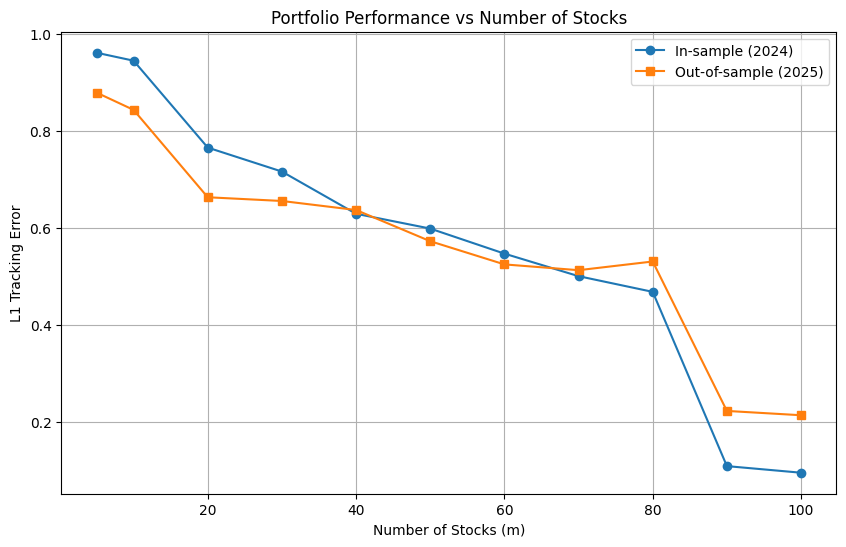

In [52]:
df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df_results['m'], df_results['L1_2024'], marker='o', label='In-sample (2024)')
plt.plot(df_results['m'], df_results['L1_2025'], marker='s', label='Out-of-sample (2025)')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('L1 Tracking Error')
plt.title('Portfolio Performance vs Number of Stocks')
plt.legend()
plt.grid(True)
plt.show()

Decision Variables:

$w_j$ - portfolio weight on stock j

$y_j \in \{0, 1\}$ - Binary variable for stock selection

$e_t \geq 0$ - absolute tracking error at time t

$min \sum_t e_t$

s.t.

$e_t \geq q_t - \sum_j w_j r_{t,j}$

$e_t \geq -q_t - \sum_j w_j r_{t,j}$

$\sum_j y_j = m$


$w_j \leq M y_j$ for $j = 1, ..., N$

$w_j \geq 0$

$w_j \in \mathbb{R}$

$y_j \in \{0,1\}$, $e_t \geq 0$

In [53]:
def fit_sparse_weights_MIP_L1(rets_mat: np.ndarray, q_vec: np.ndarray, m: int, env, time_limit_sec=3600, nonneg=True, verbose=False):
    T, N = rets_mat.shape
    mdl = gp.Model("sparse_weight_fit_L1", env=env)
    mdl.Params.OutputFlag = 1 if verbose else 0
    mdl.Params.TimeLimit = time_limit_sec


    w = mdl.addVars(N, lb=0.0 if nonneg else -GRB.INFINITY, name="w")
    y = mdl.addVars(N, vtype=GRB.BINARY, name="y")
    e = mdl.addVars(T, lb=0.0, name="e")

    #abs value linearization
    for t in range(T):
        mdl.addConstr(e[t] >= q_vec[t] - gp.quicksum(w[j] * rets_mat[t, j] for j in range(N)))
        mdl.addConstr(e[t] >= -q_vec[t] + gp.quicksum(w[j] * rets_mat[t, j] for j in range(N)))

    #budget + sparsity
    mdl.addConstr(gp.quicksum(w[j] for j in range(N)) == 1.0)
    mdl.addConstr(gp.quicksum(y[j] for j in range(N)) == m)

    #big-M linking (M=1 is tight under nonneg + budget)
    M = 1.0
    for j in range(N):
        mdl.addConstr(w[j] <= M * y[j])

    mdl.setObjective(gp.quicksum(e[t] for t in range(T)), GRB.MINIMIZE)
    mdl.optimize()

    w_sol = np.array([w[j].X for j in range(N)])
    sel_idx = [j for j in range(N) if y[j].X > 0.5]
    total_L1 = sum(e[t].X for t in range(T))
    return w_sol, sel_idx, total_L1

In [54]:

GUROBI_TIME_LIMIT = 3600  # Time limit per m value (seconds)
M_VALUES = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
RESULTS_FILE = "mip_results.json"

import json
import os


mip_results = {}
if os.path.exists(RESULTS_FILE):
    print(f"Loading existing results from {RESULTS_FILE}")
    with open(RESULTS_FILE, 'r') as f:
        data = json.load(f)
        mip_results = data.get('results', {})
        print(f"Found {len(mip_results)} existing results")

#run MIP optimization for all m values
print(f"\nStarting MIP optimization (time limit: {GUROBI_TIME_LIMIT}s per m)")
print("="*70)

for m in M_VALUES:
    m_key = str(m)
    
    #skip if already computed
    if m_key in mip_results and mip_results[m_key].get('L1_2024') is not None:
        print(f"m={m}: Skipping (already computed)")
        continue
    
    #skip if m >= number of stocks
    if m >= R24.shape[1]:
        print(f"m={m}: Skipping (m >= number of stocks)")
        continue
    
    print(f"\nm={m}: Optimizing (time limit: {GUROBI_TIME_LIMIT}s)...")
    
    #run MIP optimization
    w_mip, sel_idx_mip, L1_2024 = fit_sparse_weights_MIP_L1(
        R24, q24, m, env=env, time_limit_sec=GUROBI_TIME_LIMIT, nonneg=True
    )
    
    #evaluate on 2025 data
    L1_2025 = float(np.sum(np.abs(q25 - R25 @ w_mip)))
    
 
    mip_results[m_key] = {
        "m": m,
        "L1_2024": float(L1_2024),
        "L1_2025": float(L1_2025),
        "selected_indices": sel_idx_mip,
        "selected_tickers": [tickers[i] for i in sel_idx_mip],
        "weights": w_mip.tolist()
    }
    
    print(f"  Completed: L1_2024={L1_2024:.6f}, L1_2025={L1_2025:.6f}")
    

    results_full = {
        "metadata": {
            "time_limit_per_m": GUROBI_TIME_LIMIT,
            "m_values": M_VALUES
        },
        "data_info": {
            "num_stocks": len(tickers),
            "num_days_2024": len(R24),
            "num_days_2025": len(R25)
        },
        "results": mip_results
    }
    with open(RESULTS_FILE, 'w') as f:
        json.dump(results_full, f, indent=2)

print("\n" + "="*70)
print("MIP Optimization Complete!")
print(f"Results saved to: {RESULTS_FILE}")


df_mip = pd.DataFrame([mip_results[str(m)] for m in M_VALUES if str(m) in mip_results])
if not df_mip.empty:
    print("\nMIP Results Summary:")
    print(df_mip[['m', 'L1_2024', 'L1_2025']].to_string(index=False))


Loading existing results from mip_results.json
Found 11 existing results

Starting MIP optimization (time limit: 3600s per m)
m=5: Skipping (already computed)
m=10: Skipping (already computed)
m=20: Skipping (already computed)
m=30: Skipping (already computed)
m=40: Skipping (already computed)
m=50: Skipping (already computed)
m=60: Skipping (already computed)
m=70: Skipping (already computed)
m=80: Skipping (already computed)
m=90: Skipping (already computed)
m=100: Skipping (already computed)

MIP Optimization Complete!
Results saved to: mip_results.json

MIP Results Summary:
  m  L1_2024  L1_2025
  5 0.737191 0.786888
 10 0.426672 0.443651
 20 0.234535 0.287903
 30 0.159733 0.250019
 40 0.128963 0.261096
 50 0.109416 0.218355
 60 0.102466 0.230937
 70 0.096319 0.220670
 80 0.094726 0.212942
 90 0.094411 0.217150
100 0.094411 0.217150
